In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from ugradiolab.data import Record
from ugradiolab.analysis import Spectrum

/home/ikaros/projects/ay-121/.venv/lib/python3.12/site-packages/rtlsdr/__init__.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
CAL_DIR = Path('../../data/lab2_1_cal')

cal_records = sorted(
    [Record.load(p) for p in CAL_DIR.glob('*.npz')],
    key=lambda r: r.siggen_amp,
)
cal_spectra = [Spectrum.from_record(r) for r in cal_records]

for r, spec in zip(cal_records, cal_spectra):
    print(f'  siggen={r.siggen_freq/1e6:.3f} MHz  amp={r.siggen_amp:.0f} dBm  '
          f'nblocks={r.nblocks}  total_power={spec.total_power:.4f}')

  siggen=1421.000 MHz  amp=-80 dBm  nblocks=2048  total_power=37.4349
  siggen=1421.000 MHz  amp=-60 dBm  nblocks=2048  total_power=40.3238
  siggen=1421.000 MHz  amp=-40 dBm  nblocks=2048  total_power=377.2415


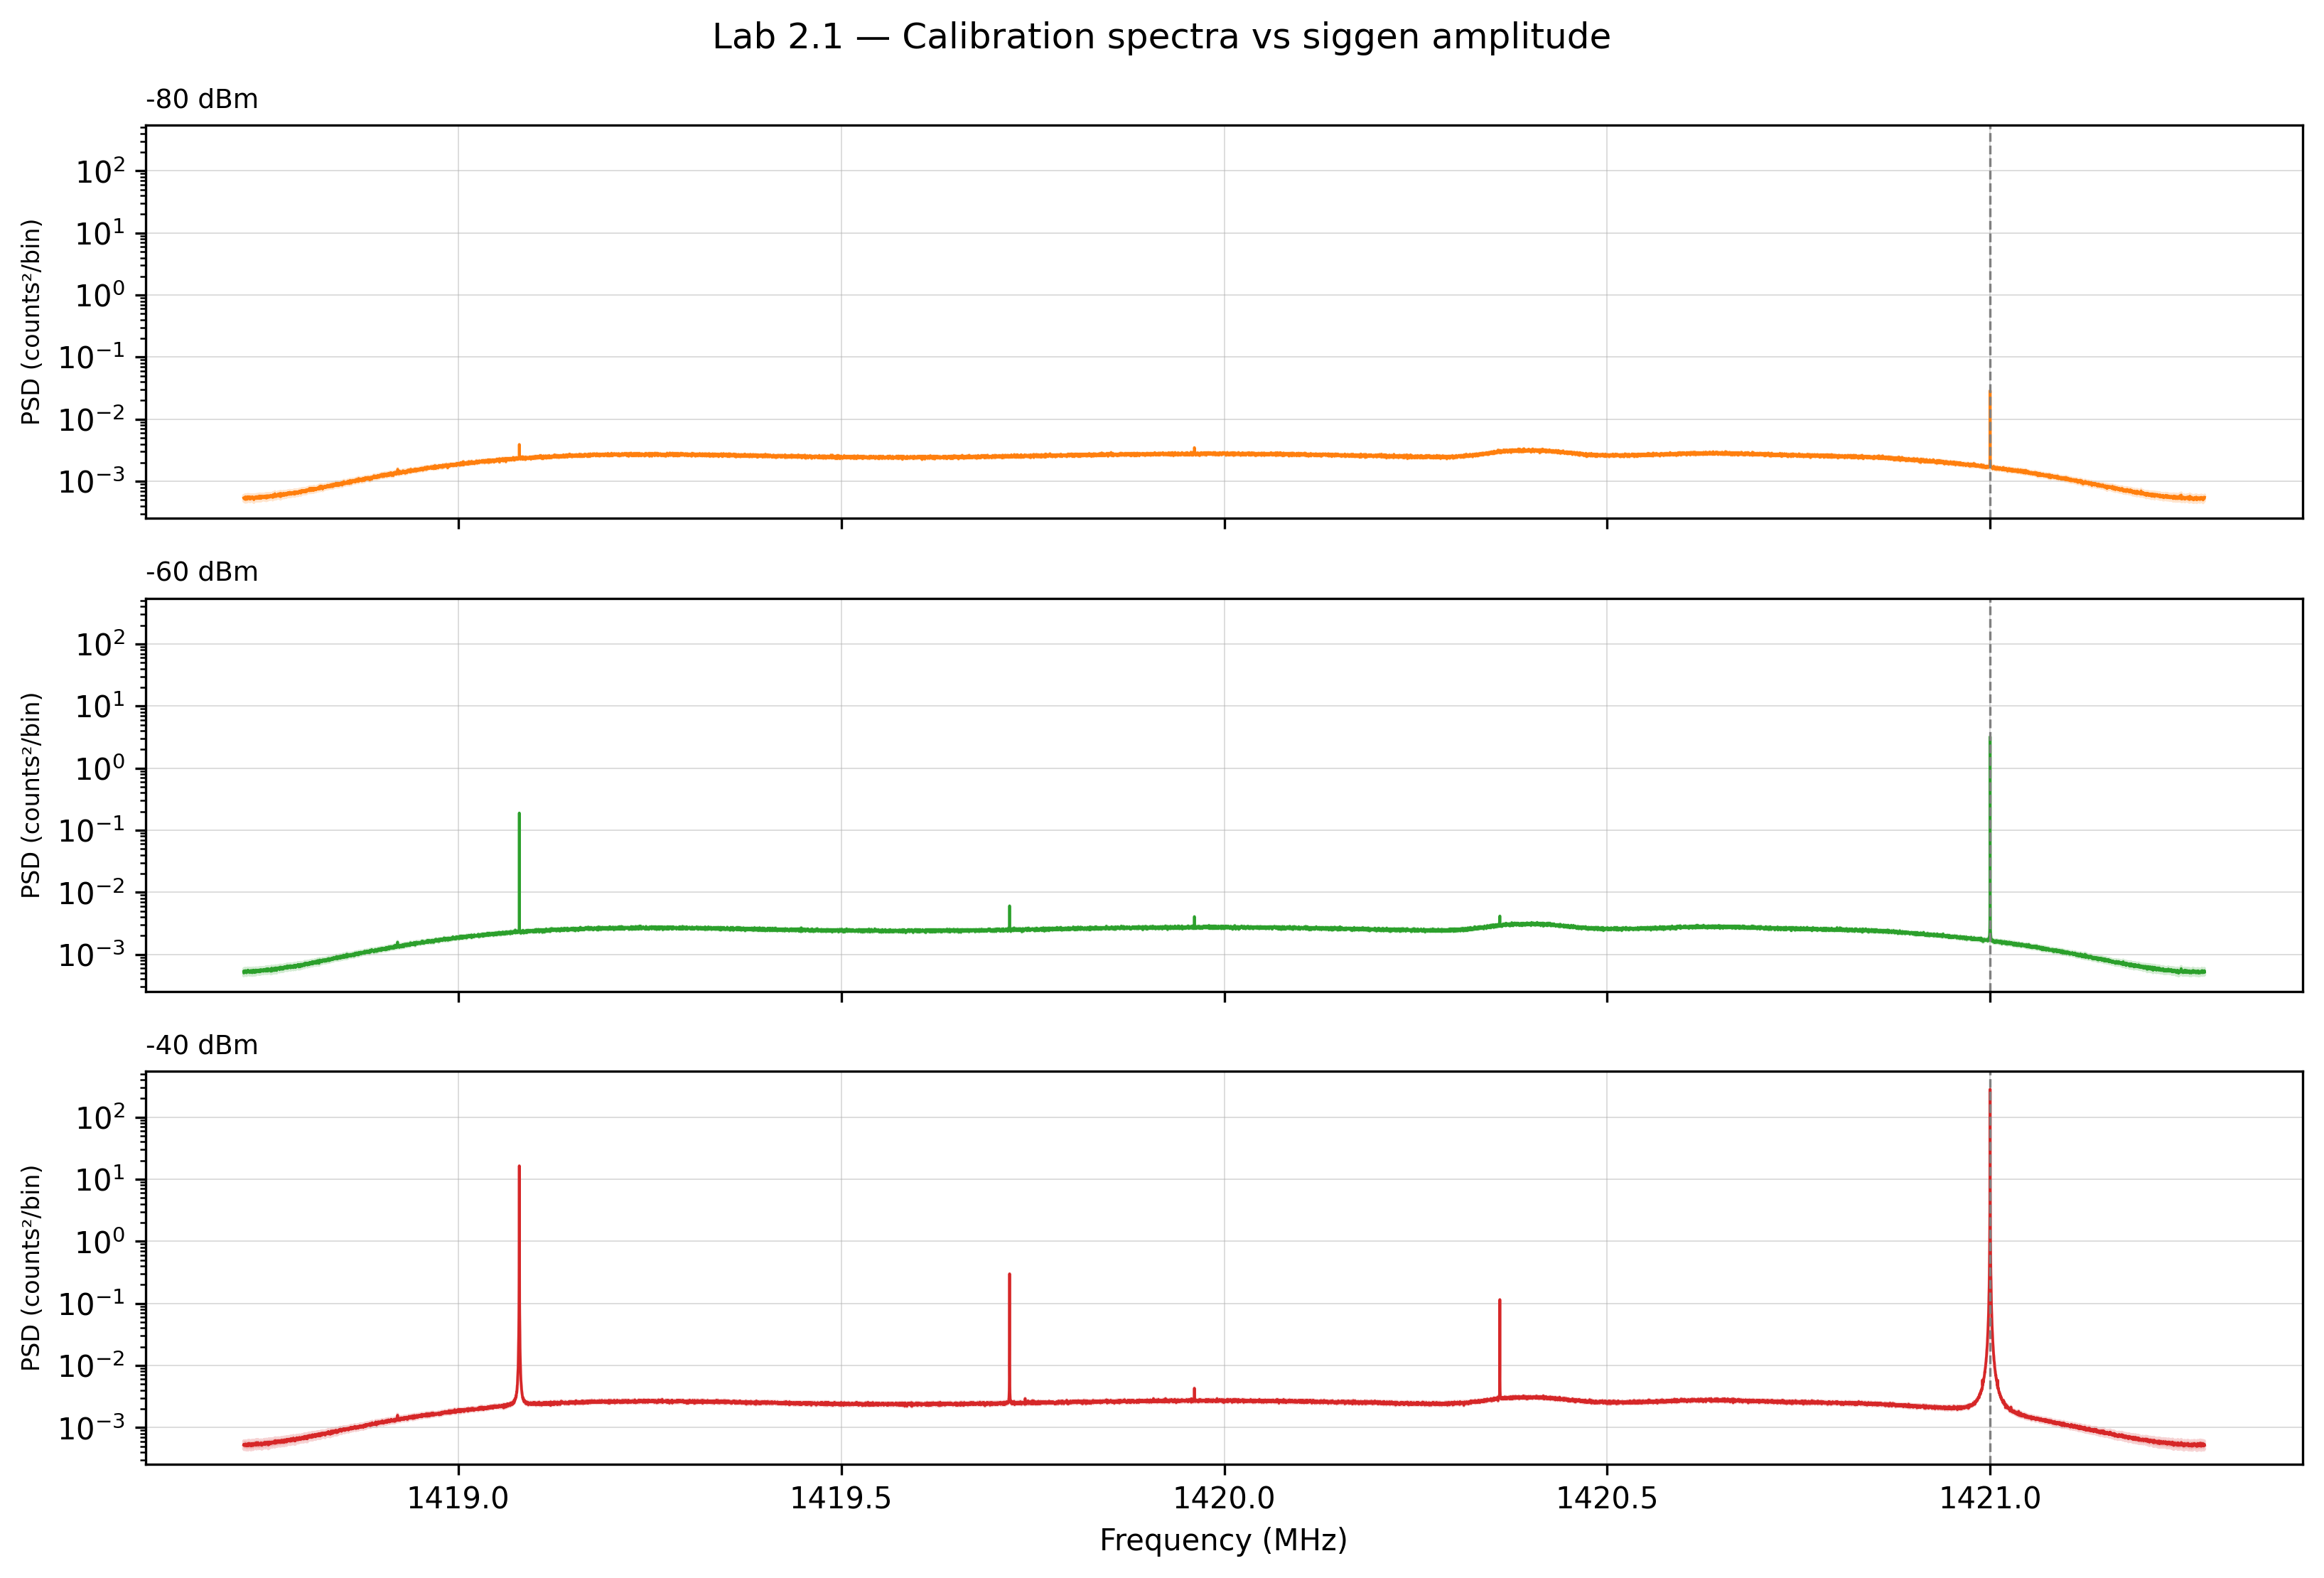

In [3]:
colors = ['C1', 'C2', 'C3']

# Precompute masked PSDs and collect global range
all_psd = []
for rec, spec in zip(cal_records, cal_spectra):
    psd = spec.psd.copy()
    psd[spec.bin_at(rec.center_freq)] = np.nan
    all_psd.append(psd)

finite_psd = np.concatenate([p[np.isfinite(p)] for p in all_psd])
y_min, y_max = finite_psd.min(), finite_psd.max()
y_pad = 0.05 * (np.log10(y_max) - np.log10(y_min))

n = len(cal_records)
fig, axes = plt.subplots(n, 1, figsize=(11, 2.5 * n), dpi=300, sharex=True, sharey=True)

for ax, rec, spec, psd, color in zip(axes, cal_records, cal_spectra, all_psd, colors):
    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std,
                    color=color, alpha=0.2)
    ax.semilogy(spec.freqs_mhz, psd, color=color, lw=0.9,
                label=f'{rec.siggen_amp:.0f} dBm @ {r.siggen_freq/1e6:.3f} MHz')
    ax.axvline(rec.siggen_freq / 1e6, color='gray', lw=0.8, linestyle='--')
    ax.set_ylabel('PSD (counts²/bin)', fontsize=8)
    ax.set_title(f'{rec.siggen_amp:.0f} dBm', fontsize=9, loc='left')
    ax.grid(True, lw=0.4, alpha=0.5)

axes[0].set_ylim(10 ** (np.log10(y_min) - y_pad), 10 ** (np.log10(y_max) + y_pad))
axes[-1].set_xlabel('Frequency (MHz)')
fig.suptitle('Lab 2.1 — Calibration spectra vs siggen amplitude')
fig.tight_layout()
plt.show()

In [4]:
DATA_DIR = Path('../../data/lab_2_1_vary_n')

obs_files = sorted(DATA_DIR.glob('*.npz'),
                   key=lambda p: int(p.stem.split('-n')[1].split('_')[0]))

obs_records = [Record.load(p) for p in obs_files]
obs_records.sort(key=lambda r: r.nblocks)
obs_spectra = [(r.nblocks, Spectrum.from_record(r)) for r in obs_records]

for n, spec in obs_spectra:
    print(f'  nblocks={n:>5d}  total_power={spec.total_power:.4f}')

  nblocks=    8  total_power=36.4474
  nblocks=   32  total_power=36.3267
  nblocks=  128  total_power=36.4774
  nblocks=  512  total_power=36.4628
  nblocks= 2048  total_power=36.2944


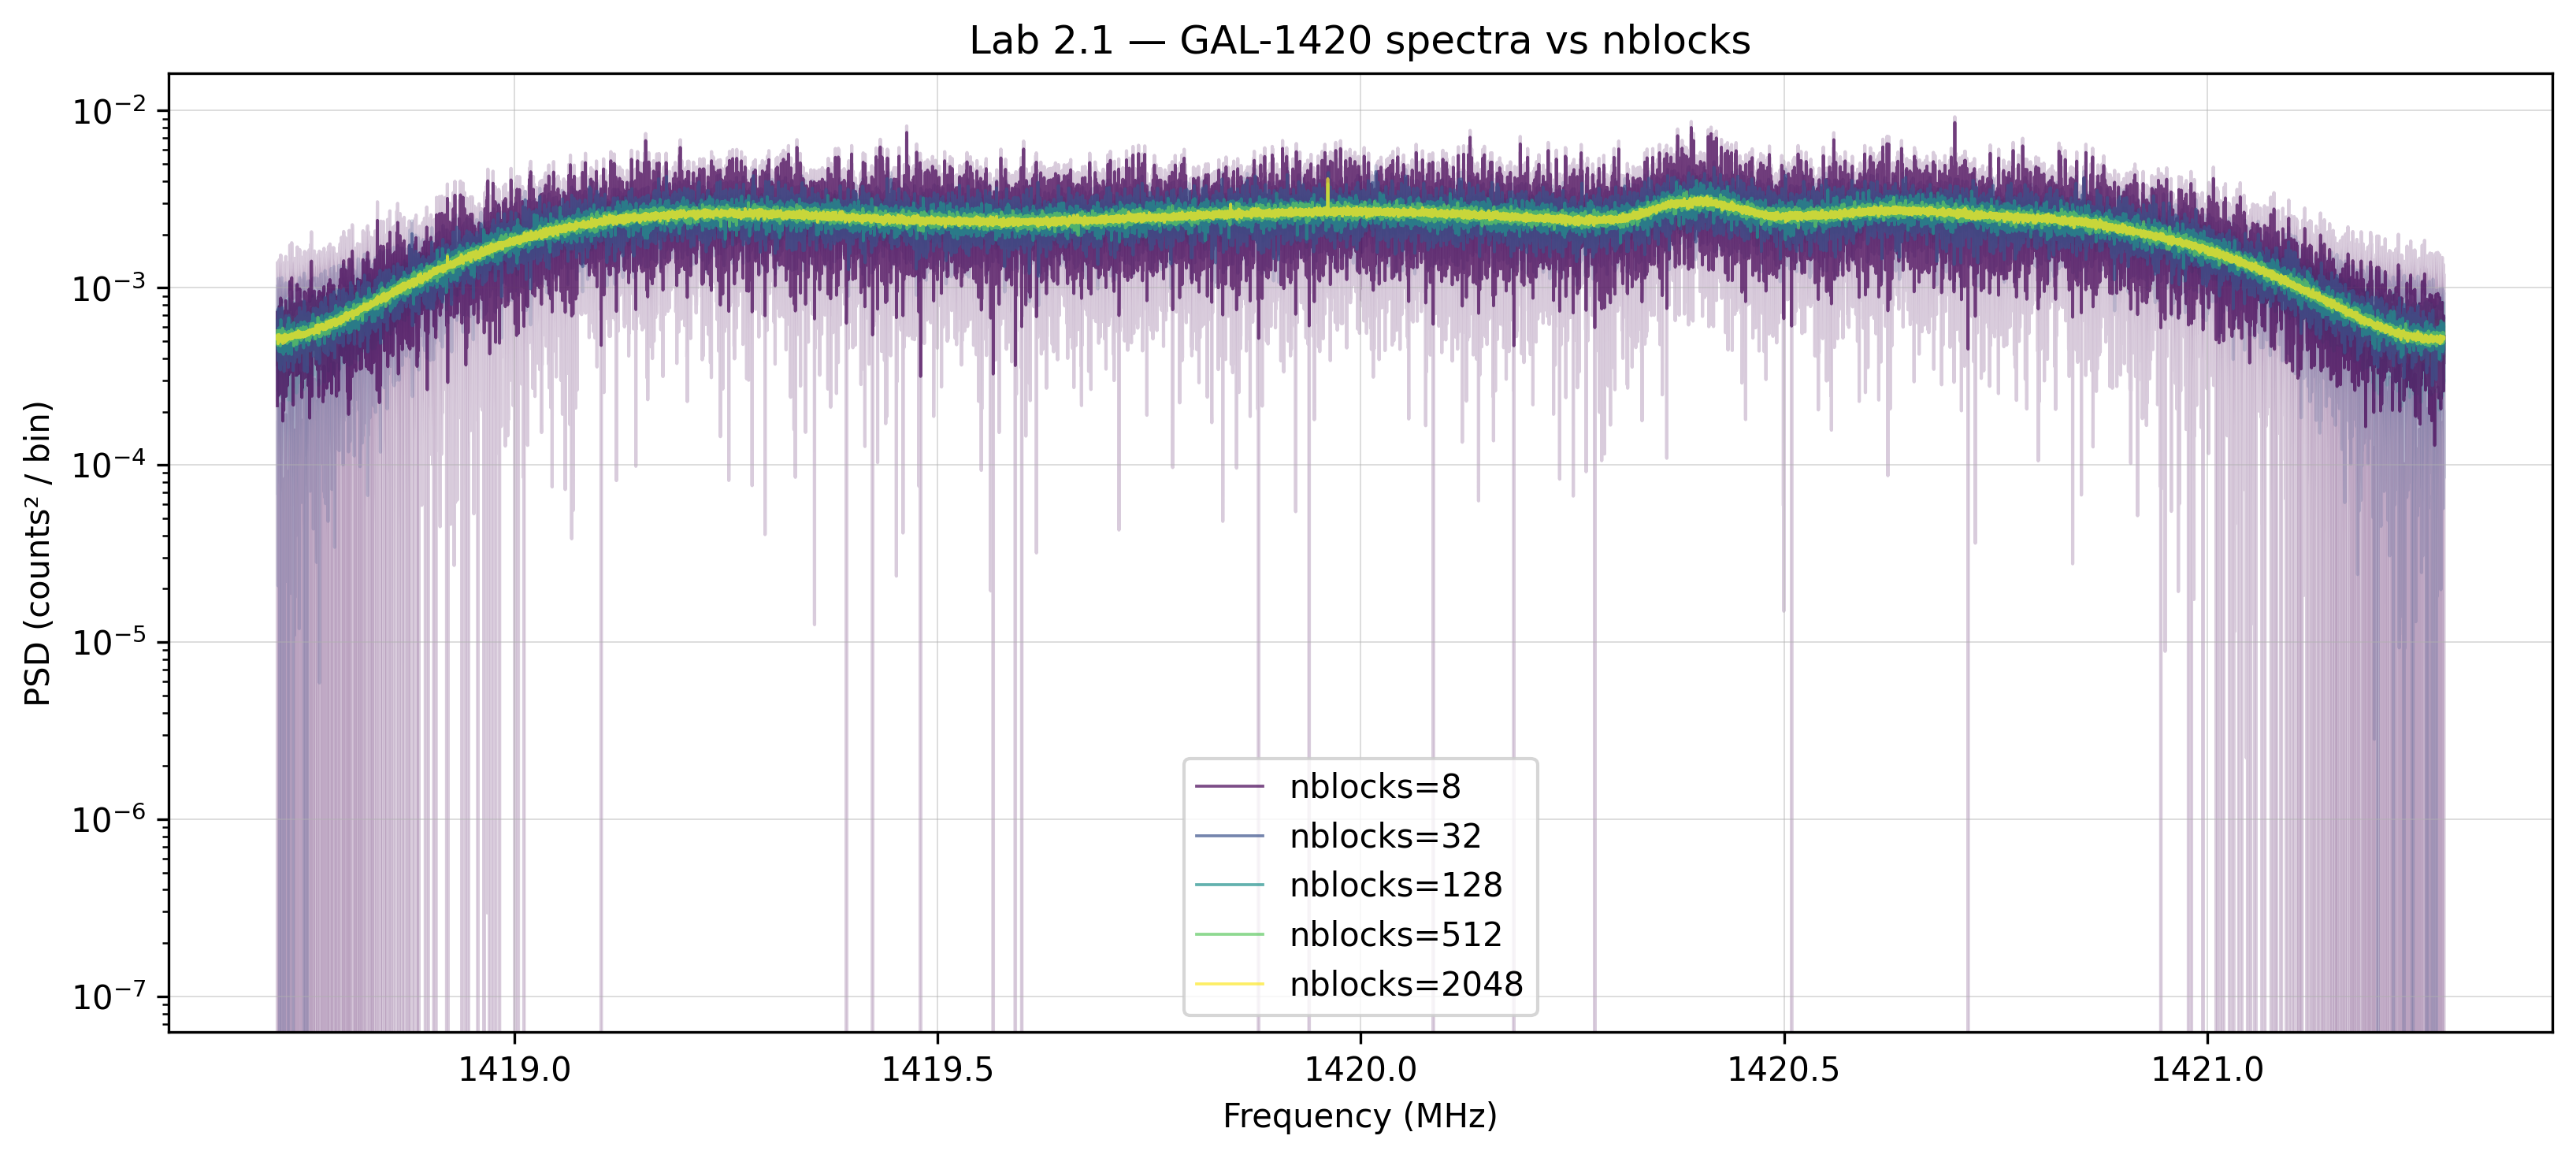

In [5]:
cmap = plt.colormaps['viridis']
colors = [cmap(i / max(len(obs_spectra) - 1, 1)) for i in range(len(obs_spectra))]

fig, ax = plt.subplots(figsize=(11, 5), dpi=300)

for rec, (n, spec), color in zip(obs_records, obs_spectra, colors):
    lo_bin = spec.bin_at(rec.center_freq)
    psd = spec.psd.copy()
    psd[lo_bin] = np.nan

    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std,
                    color=color, alpha=0.2)
    ax.semilogy(spec.freqs_mhz, psd, color=color, lw=0.9, alpha=0.7, label=f'nblocks={n}')

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts² / bin)')
ax.set_title('Lab 2.1 — GAL-1420 spectra vs nblocks')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()

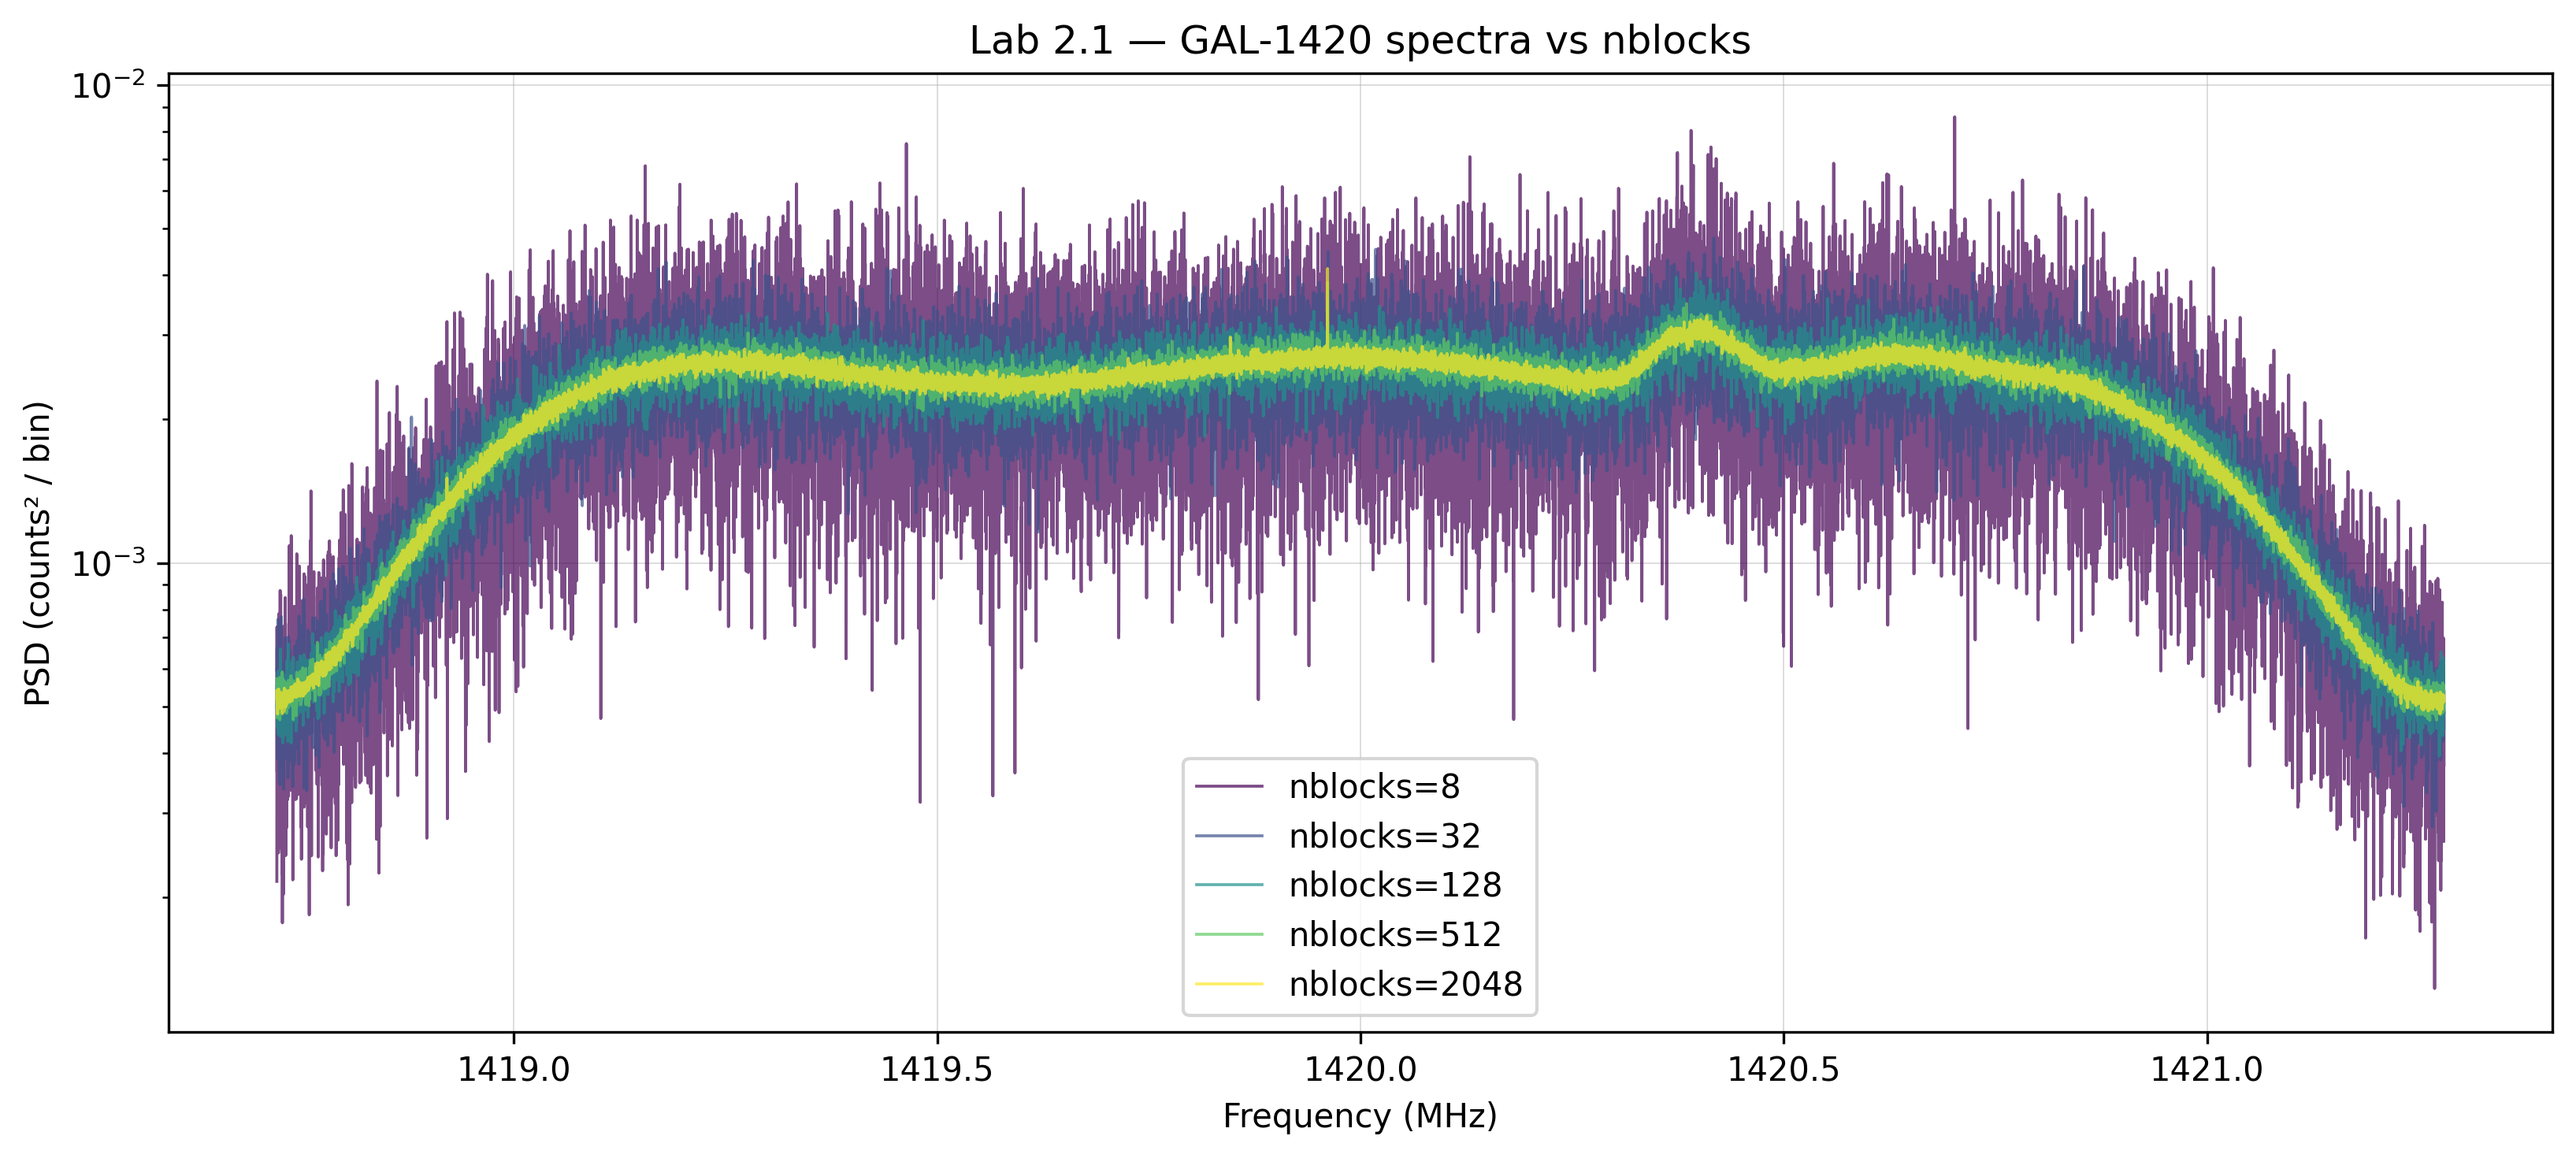

In [6]:
fig, ax = plt.subplots(figsize=(11, 5), dpi=300)

for rec, (n, spec), color in zip(obs_records, obs_spectra, colors):
    lo_bin = spec.bin_at(rec.center_freq)
    psd = spec.psd.copy()
    psd[lo_bin] = np.nan

    ax.semilogy(spec.freqs_mhz, psd, color=color, lw=0.9, alpha=0.7, label=f'nblocks={n}')

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('PSD (counts² / bin)')
ax.set_title('Lab 2.1 — GAL-1420 spectra vs nblocks')
ax.legend()
ax.grid(True, lw=0.4, alpha=0.5)
fig.tight_layout()
plt.show()

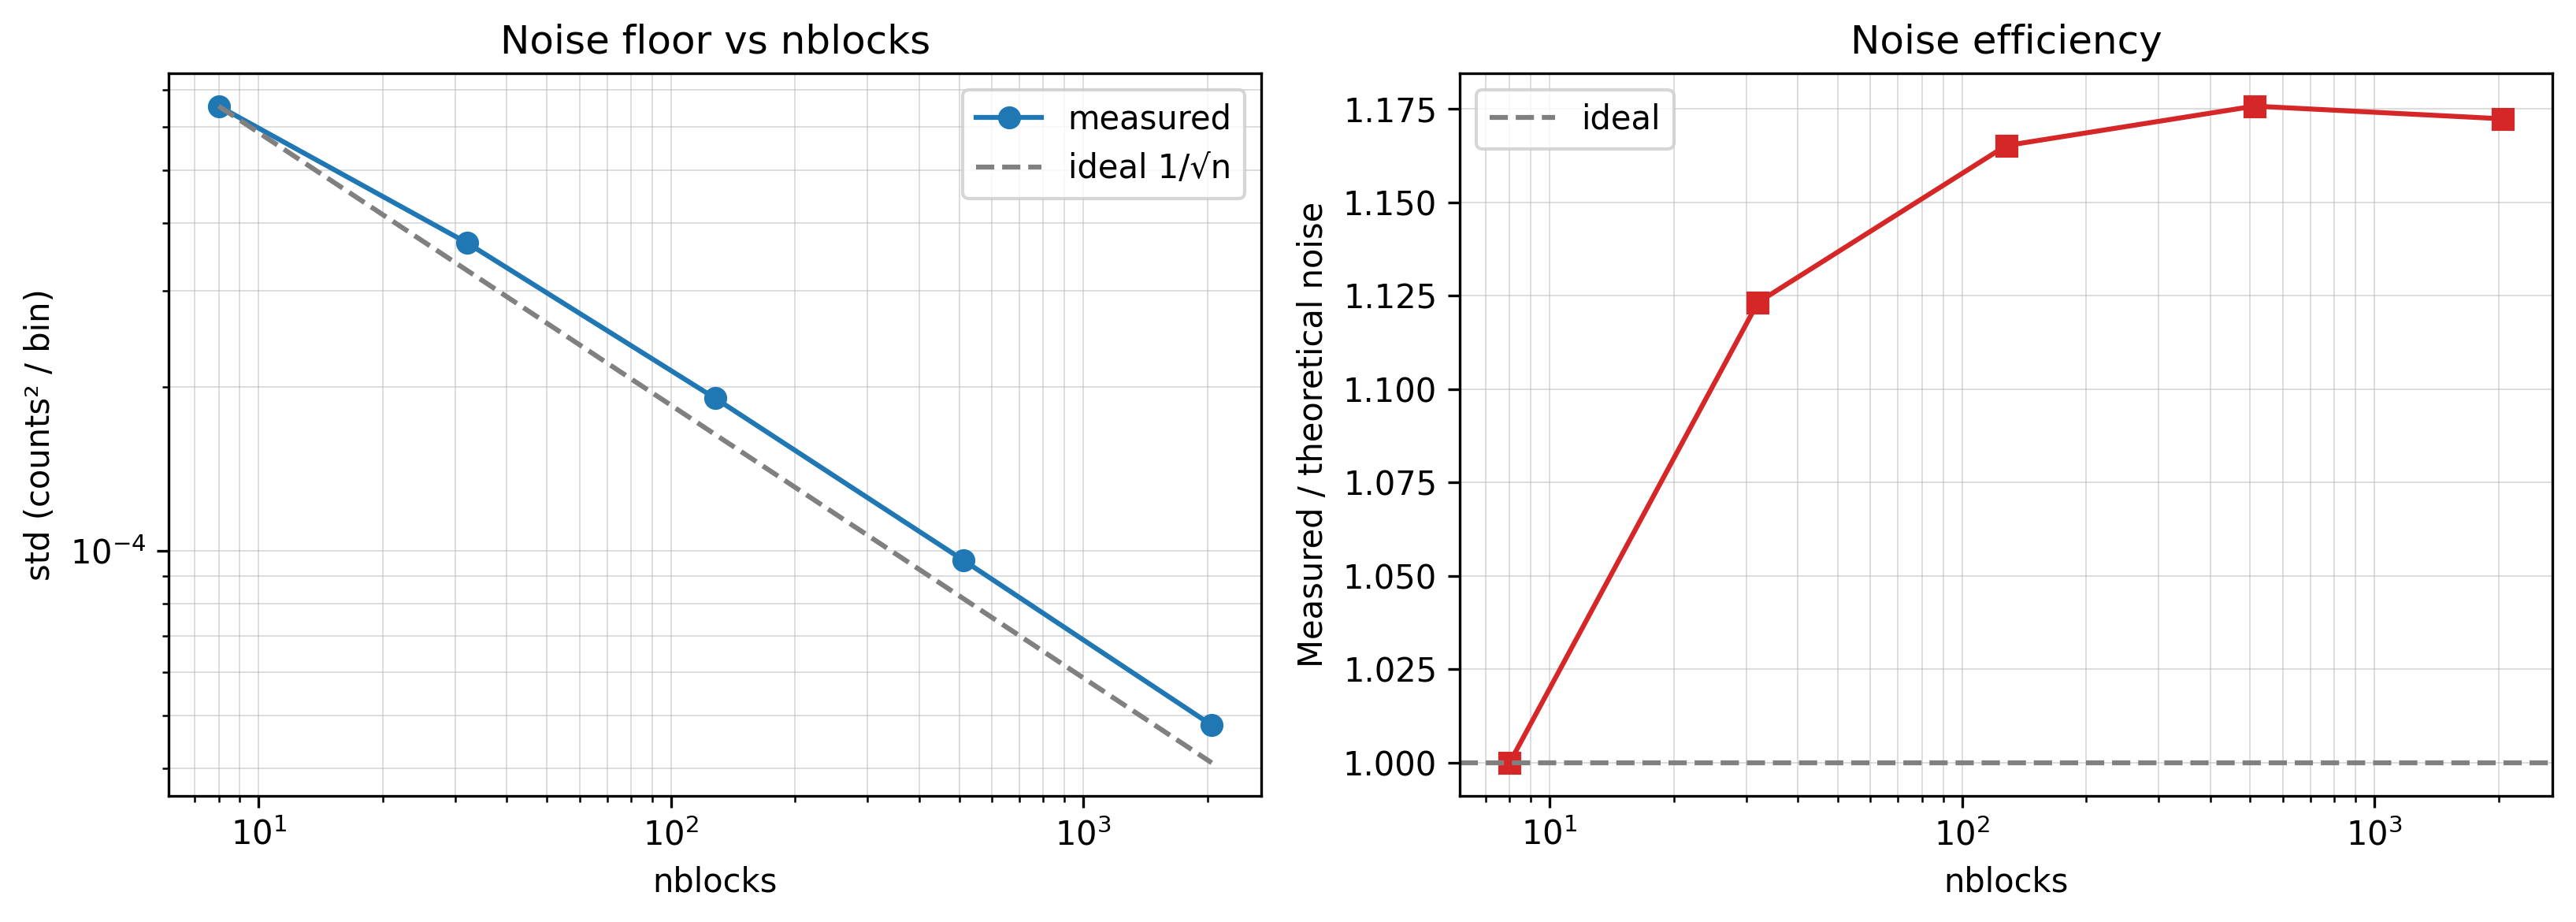

  nblocks=    8  noise=0.00065  efficiency=1.000
  nblocks=   32  noise=0.00037  efficiency=1.123
  nblocks=  128  noise=0.00019  efficiency=1.165
  nblocks=  512  noise=0.00010  efficiency=1.176
  nblocks= 2048  noise=0.00005  efficiency=1.172


In [7]:
ns    = np.array([n for n, _ in obs_spectra])
noise = np.array([spec.std for _, spec in obs_spectra])

theoretical = noise[0] / np.sqrt(ns / ns[0])
efficiency  = noise / theoretical

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4), dpi=300)

ax1.loglog(ns, noise,       'o-', label='measured')
ax1.loglog(ns, theoretical, '--', color='gray', label='ideal 1/√n')
ax1.set_xlabel('nblocks')
ax1.set_ylabel('std (counts² / bin)')
ax1.set_title('Noise floor vs nblocks')
ax1.legend()
ax1.grid(True, which='both', lw=0.4, alpha=0.5)

ax2.semilogx(ns, efficiency, 's-', color='tab:red')
ax2.axhline(1.0, color='gray', linestyle='--', label='ideal')
ax2.set_xlabel('nblocks')
ax2.set_ylabel('Measured / theoretical noise')
ax2.set_title('Noise efficiency')
ax2.legend()
ax2.grid(True, which='both', lw=0.4, alpha=0.5)

fig.tight_layout()
plt.show()

for n, s, e in zip(ns, noise, efficiency):
    print(f'  nblocks={n:>5d}  noise={s:.5f}  efficiency={e:.3f}')

In [8]:
LAB2_1_DIR = Path('../../data/lab2_1')

lo_files = sorted(
    (p for p in LAB2_1_DIR.glob('*.npz') if 'CAL' not in p.stem),
    key=lambda p: float(p.stem.split('_')[0].split('-')[1]),
)

lo_records = [Record.load(p) for p in lo_files]
lo_spectra = [Spectrum.from_record(r) for r in lo_records]

for r, spec in zip(lo_records, lo_spectra):
    print(f'  LO={r.center_freq/1e6:.0f} MHz  nblocks={r.nblocks}  total_power={spec.total_power:.4f}')

  LO=1418 MHz  nblocks=2048  total_power=37.7777
  LO=1419 MHz  nblocks=2048  total_power=36.7886
  LO=1420 MHz  nblocks=2048  total_power=36.8213
  LO=1421 MHz  nblocks=2048  total_power=35.8999
  LO=1422 MHz  nblocks=2048  total_power=34.1548
  LO=1423 MHz  nblocks=2048  total_power=34.0203


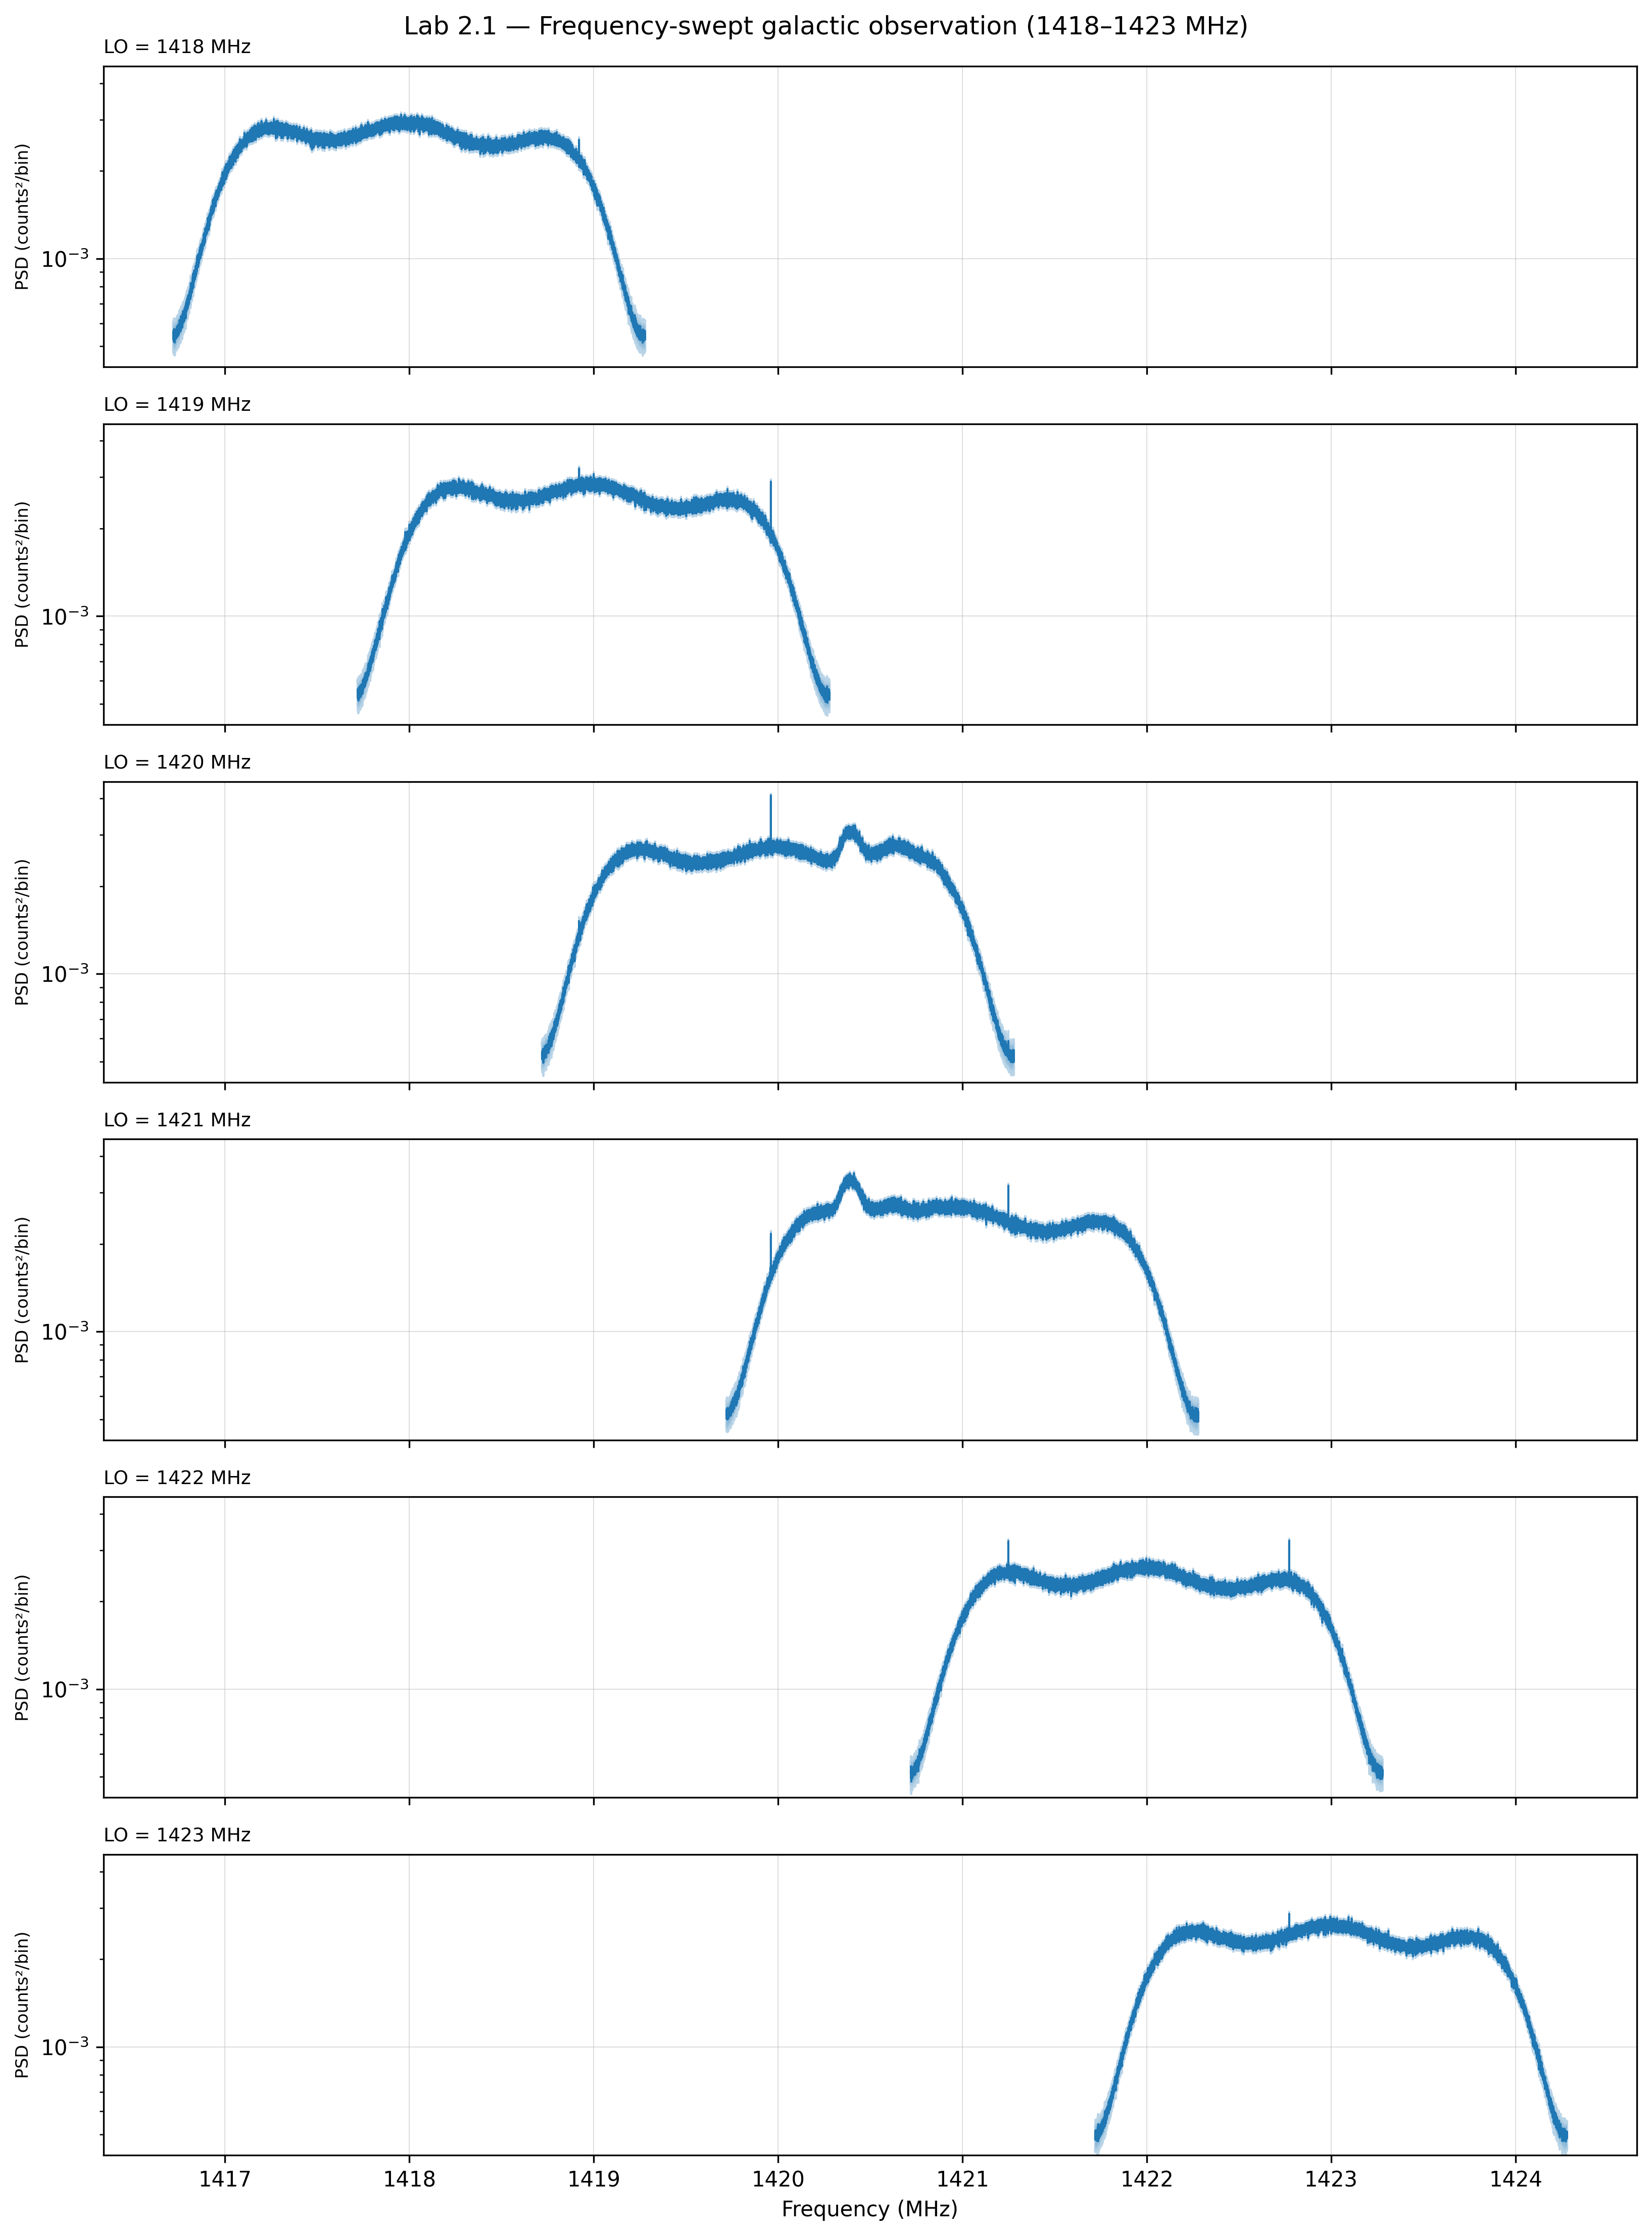

In [9]:
n = len(lo_spectra)
fig, axes = plt.subplots(n, 1, figsize=(11, 2.5 * n), dpi=300, sharex=True, sharey=True)

# Precompute masked PSDs and collect global range
all_psd = []
for rec, spec in zip(lo_records, lo_spectra):
    psd = spec.psd.copy()
    psd[spec.bin_at(rec.center_freq)] = np.nan
    all_psd.append(psd)

finite_psd = np.concatenate([p[np.isfinite(p)] for p in all_psd])
x_all = np.concatenate([spec.freqs_mhz for spec in lo_spectra])
x_min, x_max = x_all.min(), x_all.max()
y_min, y_max = finite_psd.min(), finite_psd.max()

x_pad = 0.05 * (x_max - x_min)
y_pad = 0.05 * (np.log10(y_max) - np.log10(y_min))

for ax, rec, spec, psd in zip(axes, lo_records, lo_spectra, all_psd):
    ax.fill_between(spec.freqs_mhz, psd - spec.std, psd + spec.std, alpha=0.3, color='tab:blue')
    ax.semilogy(spec.freqs_mhz, psd, lw=0.9, color='tab:blue')
    ax.set_ylabel('PSD (counts²/bin)', fontsize=8)
    ax.set_title(f'LO = {rec.center_freq/1e6:.0f} MHz', fontsize=9, loc='left')
    ax.grid(True, lw=0.4, alpha=0.5)

axes[0].set_xlim(x_min - x_pad, x_max + x_pad)
axes[0].set_ylim(10 ** (np.log10(y_min) - y_pad), 10 ** (np.log10(y_max) + y_pad))
axes[-1].set_xlabel('Frequency (MHz)')
fig.suptitle('Lab 2.1 — Frequency-swept galactic observation (1418–1423 MHz)')
fig.tight_layout()
plt.show()